In [315]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

# I want to read the full contents of the dataframes
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# Functions

In [316]:
def quick_boxplot(series,**kwargs):
    title = kwargs.get('title','Boxplot of series')
    logscale = kwargs.get('logscale',True)
    fig, ax = plt.subplots(figsize=(15,5))
    sns.boxplot(data=series,orient='h')
    plt.suptitle(title)
    if logscale:
        ax.set(xscale="log")
    plt.show()

In [317]:
def quick_histogram(series,**kwargs):
    title = kwargs.get('title','Plot of series')
    xlabel = kwargs.get('xlabel','X-axis label')
    ylabel = kwargs.get('ylabel','count')
#    plt.hist(series)
    sns.distplot(series)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [318]:
# This version of the function returns a dict of stats we can use to compare various models' performance,
#  if five folds are defined.
def kfold_xval(model,train_data,target_data,**kwargs):
    num_folds = kwargs.get('num_folds',10)
    ret_5 = kwargs.get('ret_5',num_folds==5)
    print("Cross-validation using {} folds".format(num_folds))
    cross_val_array = cross_val_score(model, train_data, target_data, cv=num_folds)
    if ret_5:
        ret_dict = {'Model': str(model),
                    'Fold_1': cross_val_array[0],
                    'Fold_2': cross_val_array[1],
                    'Fold_3': cross_val_array[2],
                    'Fold_4': cross_val_array[3],
                    'Fold_5': cross_val_array[4],
                   }
        print(ret_dict)
        return(ret_dict)
    else:
        print(cross_val_array)

In [319]:
def comp_train_test(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)

# We are making predictions here
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)

    print("R-squared of the model on the training set is: {}".format(model.score(X_train, y_train)))
    print("-----Test set statistics-----")
    print("R-squared of the model on the test set is: {}".format(model.score(X_test, y_test)))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
    print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
    

## This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

# 1. Load the houseprices data from Thinkful's database.

In [320]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


house_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA

# 2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.

In [321]:
# Filling in missing values with 0s, or "NA"
house_df['lotfrontage'].fillna(0,inplace=True)
house_df['masvnrtype'].fillna("NA",inplace=True)
house_df['masvnrarea'].fillna(0.0,inplace=True)
house_df['bsmtqual'].fillna("NA",inplace=True) 
house_df['bsmtcond'].fillna("NA",inplace=True) 
house_df['bsmtfintype1'].fillna("NA",inplace=True) 
house_df['bsmtexposure'].fillna("NA",inplace=True) 
house_df['bsmtfintype2'].fillna("NA",inplace=True) 
house_df['fireplacequ'].fillna("NA",inplace=True)
house_df['garagetype'].fillna("NA",inplace=True) 
house_df['garageyrblt'].fillna("NA",inplace=True) 
house_df['garagefinish'].fillna("NA",inplace=True) 
house_df['garagequal'].fillna("NA",inplace=True) 
house_df['garagecond'].fillna("NA",inplace=True)

In [322]:
# Dropping poorly populated or irrelevant variables
house_df.drop(columns=['id','alley','electrical','poolqc','fence','miscfeature'],inplace=True)

Performing a log transformation on lot area helps make this distribution look more normal. Let's run with that.

In [323]:
house_df['log_lotarea'] = np.log(house_df['lotarea'])

__I want to try some things:__
1. Stick with my current approach of creating a second dataframe of hand-picked variables
2. Create a dataframe that has all of the dummy variables for categorical data, and the continuous variables, and let a model (Lasso and/or ElasticNet?) pick the best variables for me. 
3. Create a copy of the dataframe in #2 that is regularized.

The following cells create the dataframes I describe in #2 and #3. My original work is below that.

In [324]:
for categorical in house_df.describe(exclude=np.number).columns:
    house_df = pd.concat([house_df, pd.get_dummies(house_df[categorical],drop_first=True,prefix=categorical)], axis=1)

In [325]:
# This grabs just the continuous variables from our dataset.
all_house_df = house_df[house_df.describe(include=np.number).columns]

# Then, concatenate dummy versions of the categorical variables.
all_house_df = pd.concat([all_house_df,pd.get_dummies(house_df.describe(exclude=np.number).columns,
                                                      drop_first=True)],axis=1)
all_house_df.head()

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,log_lotarea,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,lotshape_IR2,lotshape_IR3,lotshape_Reg,landcontour_HLS,landcontour_Low,landcontour_Lvl,utilities_NoSeWa,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,landslope_Mod,landslope_Sev,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,condition1_Feedr,condition1_Norm,condition1_PosA,condition1_PosN,condition1_RRAe,condition1_RRAn,condition1_RRNe,condition1_RRNn,condition2_Feedr,condition2_Norm,condition2_PosA,condition2_PosN,condition2_RRAe,condition2_RRAn,condition2_RRNn,bldgtype_2fmCon,bldgtype_Duplex,bldgtype_Twnhs,bldgtype_TwnhsE,housestyle_1.5Unf,housestyle_1Story,housestyle_2.5Fin,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl,roofstyle_Gable,roofstyle_Gambrel,roofstyle_Hip,roofstyle_Mansard,roofstyle_Shed,roofmatl_CompShg,roofmatl_Membran,roofmatl_Metal,roofmatl_Roll,roofmatl_Tar&Grv,roofmatl_WdShake,roofmatl_WdShngl,exterior1st_AsphShn,exterior1st_BrkComm,exterior1st_BrkFace,exterior1st_CBlock,exterior1st_CemntBd,exterior1st_HdBoard,exterior1st_ImStucc,exterior1st_MetalSd,exterior1st_Plywood,exterior1st_Stone,exterior1st_Stucco,exterior1st_VinylSd,exterior1st_Wd Sdng,exterior1st_WdShing,exterior2nd_AsphShn,exterior2nd_Brk Cmn,exterior2nd_BrkFace,exterior2nd_CBlock,exterior2nd_CmentBd,exterior2nd_HdBoard,exterior2nd_ImStucc,exterior2nd_MetalSd,exterior2nd_Other,exterior2nd_Plywood,exterior2nd_Stone,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,masvnrtype_BrkFace,masvnrtype_NA,masvnrtype_None,masvnrtype_Stone,exterqual_Fa,exterqual_Gd,exterqual_TA,extercond_Fa,extercond_Gd,extercond_Po,extercond_TA,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,bsmtqual_Fa,bsmtqual_Gd,bsmtqual_NA,bsmtqual_TA,bsmtcond_Gd,bsmtcond_NA,bsmtcond_Po,bsmtcond_TA,bsmtexposure_Gd,bsmtexposure_Mn,bsmtexposure_NA,bsmtexposure_No,bsmtfintype1_BLQ,bsmtfintype1_GLQ,bsmtfintype1_LwQ,bsmtfintype1_NA,bsmtfintype1_Rec,bsmtfintype1_Unf,bsmtfintype2_BLQ,bsmtfintype2_GLQ,bsmtfintype2_LwQ,bsmtfintype2_NA,bsmtfintype2_Rec,bsmtfintype2_Unf,heating_GasA,heating_GasW,heating_Grav,heating_OthW,heating_Wall,heatingqc_Fa,heatingqc_Gd,heatingqc_Po,heatingqc_TA,centralair_Y,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,fireplacequ_Fa,fireplacequ_Gd,fireplacequ_NA,fireplacequ_Po,fireplacequ_TA,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagetype_NA,garageyrblt_1906.0,garageyrblt_1908.0,garageyrblt_1910.0,garageyrblt_1914.0,garageyrblt_1915.0,garageyrblt_1916.0,garageyrblt_1918.0,garageyrblt_1920.0,garageyrblt_1921.0,garageyrblt_1922.0,garageyrblt_1923.0,garageyrblt_1924.0,garageyrblt_1925.0,garageyrblt_1926.0,garageyrblt_1927.0,garageyrblt_1928.0,garageyrblt_1929.0,garageyrblt_1930.0,garageyrblt_1931.0,garageyrblt_1932.0,garageyrblt_1933.0,garageyrblt_1934.0,garageyrblt_1935.0,garageyrblt_1936.0,garageyrblt_1937.0,garageyrblt_1938.0,garageyrblt_1939.0,garageyrblt_1940.0,garageyrblt_1941.0,garageyrblt_1942.0,garageyrblt_1945.0,ga

In [326]:
# I'm introducing a handful of columns with NaNs, somehow. Let's delete those.
bad_list = []
for column in all_house_df.columns:
    if all_house_df[column].count() < 1460:
        bad_list.append(column)
all_house_df = all_house_df.drop(columns=bad_list)

In [327]:
all_house_df['log_saleprice'] = np.log(all_house_df['saleprice'])
all_house_df = all_house_df.drop(columns=['saleprice'])

In [328]:
# Scale the features so we can more easily determine which are the most significant
scaler = StandardScaler()
scaled_all_house_arr = scaler.fit_transform(all_house_df)

In [329]:
scaled_all_house_df = pd.DataFrame(scaled_all_house_arr,columns=all_house_df.columns)

In [330]:
scaled_all_house_df.describe()

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,log_lotarea,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,lotshape_IR2,lotshape_IR3,lotshape_Reg,landcontour_HLS,landcontour_Low,landcontour_Lvl,utilities_NoSeWa,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,landslope_Mod,landslope_Sev,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,condition1_Feedr,condition1_Norm,condition1_PosA,condition1_PosN,condition1_RRAe,condition1_RRAn,condition1_RRNe,condition1_RRNn,condition2_Feedr,condition2_Norm,condition2_PosA,condition2_PosN,condition2_RRAe,condition2_RRAn,condition2_RRNn,bldgtype_2fmCon,bldgtype_Duplex,bldgtype_Twnhs,bldgtype_TwnhsE,housestyle_1.5Unf,housestyle_1Story,housestyle_2.5Fin,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl,roofstyle_Gable,roofstyle_Gambrel,roofstyle_Hip,roofstyle_Mansard,roofstyle_Shed,roofmatl_CompShg,roofmatl_Membran,roofmatl_Metal,roofmatl_Roll,roofmatl_Tar&Grv,roofmatl_WdShake,roofmatl_WdShngl,exterior1st_AsphShn,exterior1st_BrkComm,exterior1st_BrkFace,exterior1st_CBlock,exterior1st_CemntBd,exterior1st_HdBoard,exterior1st_ImStucc,exterior1st_MetalSd,exterior1st_Plywood,exterior1st_Stone,exterior1st_Stucco,exterior1st_VinylSd,exterior1st_Wd Sdng,exterior1st_WdShing,exterior2nd_AsphShn,exterior2nd_Brk Cmn,exterior2nd_BrkFace,exterior2nd_CBlock,exterior2nd_CmentBd,exterior2nd_HdBoard,exterior2nd_ImStucc,exterior2nd_MetalSd,exterior2nd_Other,exterior2nd_Plywood,exterior2nd_Stone,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,masvnrtype_BrkFace,masvnrtype_NA,masvnrtype_None,masvnrtype_Stone,exterqual_Fa,exterqual_Gd,exterqual_TA,extercond_Fa,extercond_Gd,extercond_Po,extercond_TA,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,bsmtqual_Fa,bsmtqual_Gd,bsmtqual_NA,bsmtqual_TA,bsmtcond_Gd,bsmtcond_NA,bsmtcond_Po,bsmtcond_TA,bsmtexposure_Gd,bsmtexposure_Mn,bsmtexposure_NA,bsmtexposure_No,bsmtfintype1_BLQ,bsmtfintype1_GLQ,bsmtfintype1_LwQ,bsmtfintype1_NA,bsmtfintype1_Rec,bsmtfintype1_Unf,bsmtfintype2_BLQ,bsmtfintype2_GLQ,bsmtfintype2_LwQ,bsmtfintype2_NA,bsmtfintype2_Rec,bsmtfintype2_Unf,heating_GasA,heating_GasW,heating_Grav,heating_OthW,heating_Wall,heatingqc_Fa,heatingqc_Gd,heatingqc_Po,heatingqc_TA,centralair_Y,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,fireplacequ_Fa,fireplacequ_Gd,fireplacequ_NA,fireplacequ_Po,fireplacequ_TA,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagetype_NA,garageyrblt_1906.0,garageyrblt_1908.0,garageyrblt_1910.0,garageyrblt_1914.0,garageyrblt_1915.0,garageyrblt_1916.0,garageyrblt_1918.0,garageyrblt_1920.0,garageyrblt_1921.0,garageyrblt_1922.0,garageyrblt_1923.0,garageyrblt_1924.0,garageyrblt_1925.0,garageyrblt_1926.0,garageyrblt_1927.0,garageyrblt_1928.0,garageyrblt_1929.0,garageyrblt_1930.0,garageyrblt_1931.0,garageyrblt_1932.0,garageyrblt_1933.0,garageyrblt_1934.0,garageyrblt_1935.0,garageyrblt_1936.0,garageyrblt_1937.0,garageyrblt_1938.0,garageyrblt_1939.0,garageyrblt_1940.0,garageyrblt_1941.0,garageyrblt_1942.0,garageyrblt_1945.0,garageyrblt_

Here's my original work to create some features I thought may be interesting. None of them turn out to be significant enough to stick around in the model, which I learned by looking at the heatmap (easy way to visualize the correlation matrix).

In [331]:
house_df['has_porch'] = ((house_df['openporchsf'] > 0) | (house_df['enclosedporch'] > 0) | (house_df['threessnporch'] > 0) | (house_df['screenporch'] > 0)).map({True: 1, False: 0})
house_df['has_deck'] = (house_df['wooddecksf'] > 0).map({True: 1, False: 0})
house_df['has_centralair'] = (house_df['centralair'].map({'Y': 1, 'N': 0}))
house_df['has_paveddrive'] = (house_df['paveddrive'].map({'Y': 1, 'N': 0, 'P': 0}))
house_df['has_gasheat'] = (house_df['heating'].map({'GasA': 1, 'GasW': 1, 'Grav': 0,
                                                    'Wall': 0, 'OthW': 0, 'Floor': 0}))
house_df['has_fingarage'] = (house_df['garagefinish'].map({'Fin': 1, 'RFn': 1, 'Unf': 0,'NA': 0}))

In [332]:
overall_correlation = house_df.corr()

In [333]:
correlated_columns = overall_correlation['saleprice'].sort_values(ascending=False).head(20).index

In [334]:
corr_col_corr = house_df[correlated_columns].corr()

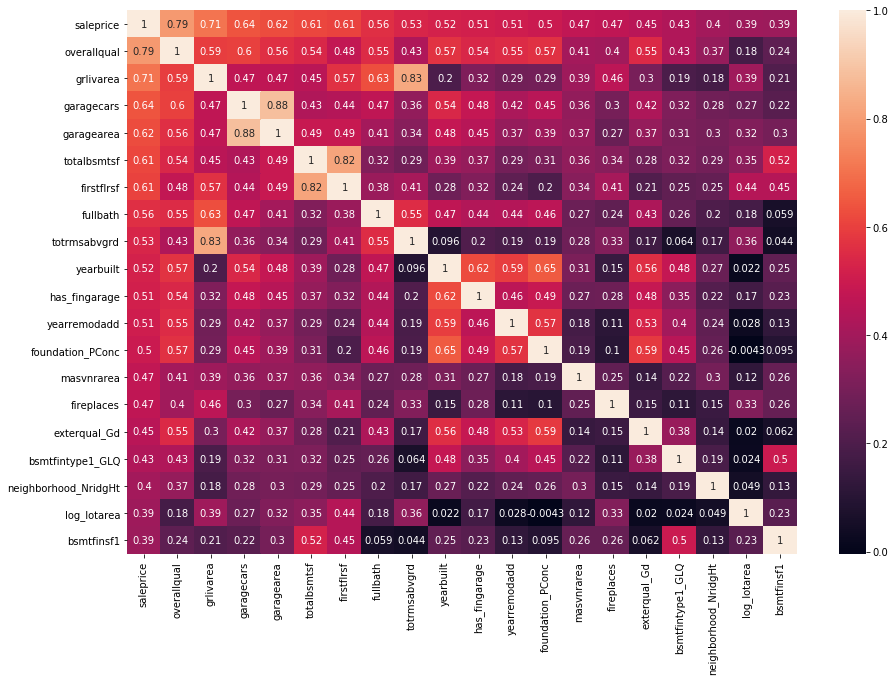

In [335]:
fig=plt.figure(figsize=(15,10))
sns.heatmap(corr_col_corr,annot=True)

In [336]:
# Start with these features of interest. 
vars_of_interest = ['grlivarea', 'garagecars', 'totalbsmtsf', 'yearbuilt',
                    'exterqual_Gd', 'fireplaces', 'bsmtfintype1_GLQ', 
                    'log_lotarea', 'neighborhood_NridgHt',
                   ]

import copy
int_plus_saleprice = copy.deepcopy(vars_of_interest)
int_plus_saleprice.append('saleprice')

# Create a copy of the dataframe that's just these variables--it'll be easier to manage/manipulate
house_interest_df = house_df[int_plus_saleprice]
house_interest_df.head()

,grlivarea,garagecars,totalbsmtsf,yearbuilt,exterqual_Gd,fireplaces,bsmtfintype1_GLQ,log_lotarea,neighborhood_NridgHt,saleprice
0,1710,2,856,2003,1,0,1,9.041922,0,208500
1,1262,2,1262,1976,0,1,0,9.169518,0,181500
2,1786,2,920,2001,1,1,1,9.328123,0,223500
3,1717,3,756,1915,0,1,0,9.164296,0,140000
4,2198,3,1145,2000,1,1,1,9.565214,0,250000


In [337]:
# Remove a handful of huge outliers from the dataset before we begin training.
# I learned this technique from the Udemy course I've also been working through.
q = house_interest_df['saleprice'].quantile(.99)
house_interest_df = house_interest_df[house_interest_df['saleprice'] < q]

In [338]:
house_interest_df.describe(include='all')

,grlivarea,garagecars,totalbsmtsf,yearbuilt,exterqual_Gd,fireplaces,bsmtfintype1_GLQ,log_lotarea,neighborhood_NridgHt,saleprice
count,1445.000000,1445.000000,1445.00000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000
mean,1500.154325,1.754325,1047.15917,1971.004844,0.334948,0.604152,0.281661,9.103920,0.048443,177082.510035
std,500.813151,0.740492,426.37156,30.109369,0.472136,0.640061,0.449965,0.513978,0.214775,69614.603756
min,334.000000,0.000000,0.00000,1872.000000,0.000000,0.000000,0.000000,7.170120,0.000000,34900.000000
25%,1126.000000,1.000000,794.00000,1954.000000,0.000000,0.000000,0.000000,8.922658,0.000000,129900.000000
50%,1456.000000,2.000000,988.00000,1972.000000,0.000000,1.000000,0.000000,9.151651,0.000000,162000.000000
75%,1768.000000,2.000000,1278.00000,2000.000000,1.000000,1.000000,1.000000,9.348187,0.000000,212000.000000
max,5642.000000,4.000000,6110.00000,2010.000000,1.000000,3.000000,1.000000,12.279532,1.000000,440000.000000


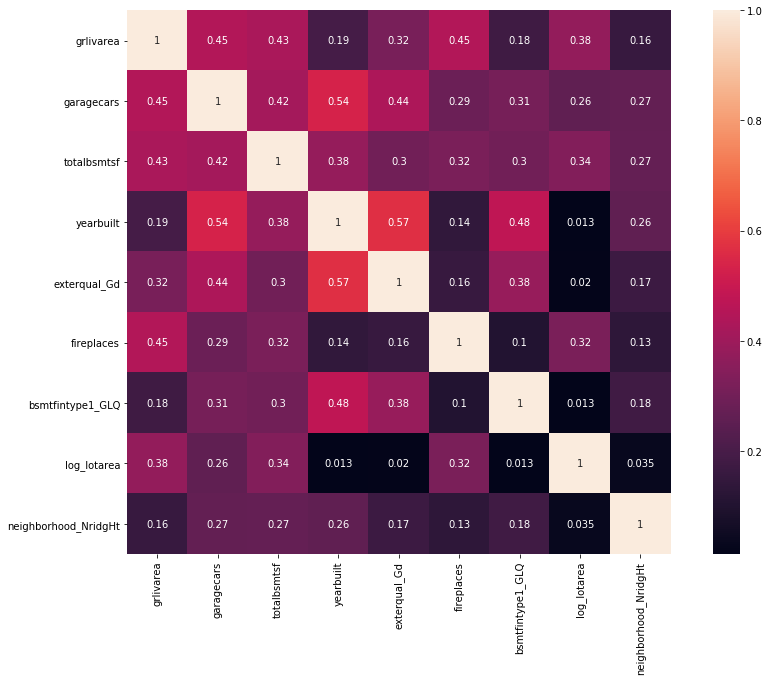

In [339]:
fig=plt.figure(figsize=(15,10))
sns.heatmap(house_interest_df[vars_of_interest].corr(),annot=True,square=True)

# 3. Now, split your data into train and test sets where 20% of the data resides in the test set.

__NOTE:__ Performing a log transformation on the dependent variable (home sale price) made its distribution much more normal, and made the model fit better. 

In the "all" and scaled datasets, I perform this log transformation and use that column instead. The original column was dropped to prevent multicollinearity issues.

In [340]:
# Y is the target variable
Y = np.log(house_interest_df['saleprice'])

# X is the feature set.
X = house_interest_df[vars_of_interest]

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1156
The number of observations in test set is 289


Copy of the dataset with all of the categorical variables blown out into dummy features:

In [342]:
# This is the version of the dataset that includes all categorical as well as continuous features 
X_all = all_house_df.drop(columns=['log_saleprice'])
Y_all = all_house_df['log_saleprice']

Xall_train, Xall_test, yall_train, yall_test = train_test_split(X_all, Y_all, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(Xall_train.shape[0]))
print("The number of observations in test set is {}".format(Xall_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


Copy of the full dataset, but regularized using Scaler:

In [343]:
# How does it look if we use the scaled version of the "all" dataset instead?
X_scaled = scaled_all_house_df.drop(columns=['log_saleprice'])
Y_scaled = scaled_all_house_df['log_saleprice']

Xscl_train, Xscl_test, yscl_train, yscl_test = train_test_split(X_scaled, Y_scaled,
                                                                test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(Xscl_train.shape[0]))
print("The number of observations in test set is {}".format(Xscl_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


# 4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!

In [344]:
# Capture k-fold output in a dataframe, so comparing performance will be easier
kfold_df = pd.DataFrame(columns=['Model','Fold_1','Fold_2','Fold_3','Fold_4','Fold_5'])

### Linear Regression

In [345]:
linear = LinearRegression()
cv_results = kfold_xval(linear,X_train,y_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)', 'Fold_1': 0.8020104366686538, 'Fold_2': 0.7925822826070211, 'Fold_3': 0.8293491701280619, 'Fold_4': 0.7026293062329904, 'Fold_5': 0.8515623676483204}


In [346]:
comp_train_test(linear,X_train,y_train,X_test,y_test)

R-squared of the model on the training set is: 0.8064103635803673
-----Test set statistics-----
R-squared of the model on the test set is: 0.7127255405873931
Mean absolute error of the prediction is: 0.1249465026271885
Mean squared error of the prediction is: 0.045166332445008825
Root mean squared error of the prediction is: 0.21252372207593398
Mean absolute percentage error of the prediction is: 1.0410175148594554


In [347]:
linear_all = LinearRegression()
cv_results = kfold_xval(linear_all,Xall_train,yall_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)', 'Fold_1': -299.9504951262313, 'Fold_2': 0.7793304243307717, 'Fold_3': 0.8916872648199781, 'Fold_4': 0.6010407372220804, 'Fold_5': 0.5659198425987376}


In [348]:
comp_train_test(linear_all,Xall_train,yall_train,Xall_test,yall_test)

R-squared of the model on the training set is: 0.9518574199312564
-----Test set statistics-----
R-squared of the model on the test set is: 0.8284106936031906
Mean absolute error of the prediction is: 0.10180973773034882
Mean squared error of the prediction is: 0.028612153377688163
Root mean squared error of the prediction is: 0.169151273650801
Mean absolute percentage error of the prediction is: 0.8555018178968165


In [349]:
linear_scl = LinearRegression()
cv_results = kfold_xval(linear_scl,Xscl_train,yscl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)', 'Fold_1': -9.716447561308477e+18, 'Fold_2': -6.671546058110388e+20, 'Fold_3': -2464087843201.55, 'Fold_4': -1.6188267499445898e+23, 'Fold_5': -8.359499919280445e+21}


In [350]:
comp_train_test(linear_all,Xscl_train,yscl_train,Xscl_test,yscl_test)

R-squared of the model on the training set is: 0.9518570664412267
-----Test set statistics-----
R-squared of the model on the test set is: -1.0019522153894745e+21
Mean absolute error of the prediction is: 2471146963.6780868
Mean squared error of the prediction is: 1.0477941901798349e+21
Root mean squared error of the prediction is: 32369649213.11065
Mean absolute percentage error of the prediction is: 635147586768.4052


# WOAH.
What happened there?

### Ridge

In [351]:
ridge = Ridge()
cv_results = kfold_xval(ridge,X_train,y_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': "Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n      normalize=False, random_state=None, solver='auto', tol=0.001)", 'Fold_1': 0.8018604055127205, 'Fold_2': 0.7926650168305711, 'Fold_3': 0.8293914892765961, 'Fold_4': 0.702445249208284, 'Fold_5': 0.8517734325177087}


In [352]:
comp_train_test(ridge,X_train,y_train,X_test,y_test)

R-squared of the model on the training set is: 0.8064077759308848
-----Test set statistics-----
R-squared of the model on the test set is: 0.7124305731715002
Mean absolute error of the prediction is: 0.12485810389172007
Mean squared error of the prediction is: 0.045212708291973804
Root mean squared error of the prediction is: 0.21263280154288003
Mean absolute percentage error of the prediction is: 1.040294559486799


In [353]:
ridge_scl = Ridge()
cv_results = kfold_xval(ridge_scl,Xscl_train,yscl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': "Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n      normalize=False, random_state=None, solver='auto', tol=0.001)", 'Fold_1': 0.8247906304565259, 'Fold_2': 0.7376325241618338, 'Fold_3': 0.888091602982034, 'Fold_4': 0.5992229261015825, 'Fold_5': 0.5543706069201993}


In [354]:
comp_train_test(ridge_scl,Xscl_train,yscl_train,Xscl_test,yscl_test)

R-squared of the model on the training set is: 0.9515789557552795
-----Test set statistics-----
R-squared of the model on the test set is: 0.8868881500092929
Mean absolute error of the prediction is: 0.23125793962405788
Mean squared error of the prediction is: 0.11828701752476906
Root mean squared error of the prediction is: 0.34392879717285824
Mean absolute percentage error of the prediction is: 71.99166912302405


### Lasso

In [355]:
lasso = Lasso()
cv_results = kfold_xval(lasso,X_train,y_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': "Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n      normalize=False, positive=False, precompute=False, random_state=None,\n      selection='cyclic', tol=0.0001, warm_start=False)", 'Fold_1': 0.7388743556759736, 'Fold_2': 0.7243541801738779, 'Fold_3': 0.7544872204160755, 'Fold_4': 0.6093741598916742, 'Fold_5': 0.7970881828048506}


In [356]:
comp_train_test(lasso,X_train,y_train,X_test,y_test)

R-squared of the model on the training set is: 0.7364562607575793
-----Test set statistics-----
R-squared of the model on the test set is: 0.5600785356041682
Mean absolute error of the prediction is: 0.1465646546025085
Mean squared error of the prediction is: 0.06916604821474527
Root mean squared error of the prediction is: 0.2629943881810889
Mean absolute percentage error of the prediction is: 1.2185961407281498


With the full set of continous + dummy features available. Lasso should reduce most of the coefficients for these to zero, leaving only the significant features to influence the model. We can see which ones those are (I think?).

In [357]:
lasso_all = Lasso()
cv_results = kfold_xval(lasso_all,Xall_train,yall_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': "Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n      normalize=False, positive=False, precompute=False, random_state=None,\n      selection='cyclic', tol=0.0001, warm_start=False)", 'Fold_1': 0.7385699616678476, 'Fold_2': 0.8126811685558956, 'Fold_3': 0.7961432729325032, 'Fold_4': 0.5229494585607799, 'Fold_5': 0.7852018858720217}


In [358]:
comp_train_test(lasso_all,Xall_train,yall_train,Xall_test,yall_test)

R-squared of the model on the training set is: 0.7547846955171215
-----Test set statistics-----
R-squared of the model on the test set is: 0.8190788165820899
Mean absolute error of the prediction is: 0.11918051929081076
Mean squared error of the prediction is: 0.030168224103983864
Root mean squared error of the prediction is: 0.17369002304100217
Mean absolute percentage error of the prediction is: 0.9951197935339183


### ElasticNet

Shifting the ratio to .1, favoring the Ridge penalty over the Lasso penalty, seems to yield good results.

In [359]:
elastic = ElasticNet(l1_ratio=.1)
cv_results = kfold_xval(elastic,X_train,y_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': "ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.1,\n           max_iter=1000, normalize=False, positive=False, precompute=False,\n           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)", 'Fold_1': 0.7427200992417489, 'Fold_2': 0.7319201973648299, 'Fold_3': 0.7667991745552104, 'Fold_4': 0.6148361608409543, 'Fold_5': 0.8119450158652071}


In [360]:
comp_train_test(elastic,X_train,y_train,X_test,y_test)

R-squared of the model on the training set is: 0.7450279227507717
-----Test set statistics-----
R-squared of the model on the test set is: 0.5811130673000922
Mean absolute error of the prediction is: 0.141142611969346
Mean squared error of the prediction is: 0.06585892284987378
Root mean squared error of the prediction is: 0.2566299336590994
Mean absolute percentage error of the prediction is: 1.1742190318420447


In [361]:
elastic_scl = ElasticNet(l1_ratio=.1)
cv_results = kfold_xval(elastic_scl,Xscl_train,yscl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': "ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.1,\n           max_iter=1000, normalize=False, positive=False, precompute=False,\n           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)", 'Fold_1': 0.770613594953614, 'Fold_2': 0.7925863408993326, 'Fold_3': 0.7785271560097725, 'Fold_4': 0.7370326162574952, 'Fold_5': 0.8011461090042126}


In [362]:
comp_train_test(elastic,Xscl_train,yscl_train,Xscl_test,yscl_test)

R-squared of the model on the training set is: 0.7820074983483498
-----Test set statistics-----
R-squared of the model on the test set is: 0.7872980246552758
Mean absolute error of the prediction is: 0.3195653561593312
Mean squared error of the prediction is: 0.22243365560037645
Root mean squared error of the prediction is: 0.4716287264367772
Mean absolute percentage error of the prediction is: 83.4567013528584


## 5. Evaluate your best model on the test set.

### Comparing scores from cross-validation

In [363]:
kfold_df['avg_score'] = kfold_df.mean(axis=1)
kfold_df.sort_values(['avg_score'],ascending=False)

,Model,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,avg_score
3,"Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=None, solver='auto', tol=0.001)",8.018604e-01,7.926650e-01,8.293915e-01,7.024452e-01,8.517734e-01,7.956271e-01
0,"LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)",8.020104e-01,7.925823e-01,8.293492e-01,7.026293e-01,8.515624e-01,7.956267e-01
8,"ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.1,\n max_iter=1000, normalize=False, positive=False, precompute=False,\n random_state=None, selection='cyclic', tol=0.0001, warm_start=False)",7.706136e-01,7.925863e-01,7.785272e-01,7.370326e-01,8.011461e-01,7.759812e-01
7,"ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.1,\n max_iter=1000, normalize=False, positive=False, precompute=False,\n random_state=None, selection='cyclic', tol=0.0001, warm_start=False)",7.427201e-01,7.319202e-01,7.667992e-01,6.148362e-01,8.119450e-01,7.336441e-01
6,"Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=False, positive=False, precompute=False, random_state=None,\n selection='cyclic', tol=0.0001, warm_start=False)",7.385700e-01,8.126812e-01,7.961433e-01,5.229495e-01,7.852019e-01,7.311091e-01
5,"Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=False, positive=False, precompute=False, random_state=None,\n selection='cyclic', tol=0.0001, warm_start=False)",7.388744e-01,7.243542e-01,7.544872e-01,6.093742e-01,7.970882e-01,7.248356e-01
4,"Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=None, solver='auto', tol=0.001)",8.247906e-01,7.376325e-01,8.880916e-01,5.992229e-01,5.543706e-01,7.208217e-01
1,"LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)",-2.999505e+02,7.793304e-01,8.916873e-01,6.010407e-01,5.659198e-01,-5.942250e+01
2,"LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)",-9.716448e+18,-6.671546e+20,-2.464088e+12,-1.618827e+23,-8.359500e+21,-3.418381e+22


So the Ridge model, running against the hand-rolled dataset, gives the best average score using the training data.

### Comparing training vs. test output

What I noticed above, though, is that only two models returned higher scores for the test set than for the training set. 

The Lasso model, when fed the dataset containing all of the continuous variables, and all of the categorical variables as dummy features:
```
R-squared of the model on the training set is: 0.7547846955171215
-----Test set statistics-----
R-squared of the model on the test set is: 0.8190788165820899
Mean absolute error of the prediction is: 0.11918051929081076
Mean squared error of the prediction is: 0.030168224103983864
Root mean squared error of the prediction is: 0.17369002304100217
Mean absolute percentage error of the prediction is: 0.9951197935339183
```
And the ElasticNet model, when given the scaled version of the full dataset:
```
R-squared of the model on the training set is: 0.7820074983483498
-----Test set statistics-----
R-squared of the model on the test set is: 0.7872980246552758
Mean absolute error of the prediction is: 0.3195653561593312
Mean squared error of the prediction is: 0.22243365560037645
Root mean squared error of the prediction is: 0.4716287264367772
Mean absolute percentage error of the prediction is: 83.4567013528584
```
Between these two, the Lasso model running against the full dataset has the edge.

__Is it safe to say that the models that returned higher scores with the training data than with the test data were overfitting...?__

# CHOOSE A MODEL.

## 6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

I downloaded a CSV of quarterly real GDP per capita from the [Federal Reserve Bank of St. Louis' website](https://fred.stlouisfed.org/series/A939RX0Q048SBEA), covering the months/years sold dates in the dataset.

In [377]:
gdp_df = pd.read_csv('real_gdp_per_capita_2006_2010.csv')

In [380]:
gdp_df.rename(columns={"A939RX0Q048SBEA": "GDP"},inplace=True)

In [456]:
def lookup_gdp(month,year):
    if month in [1,2,3]:
        retmo = 1
    elif month in [4,5,6]:
        retmo = 4
    elif month in [7,8,9]:
        retmo = 7
    else:
        retmo=10
    datestr = "{}-{:02d}-01".format(year,retmo)
    return(int(gdp_df.loc[gdp_df['DATE'] == datestr]['GDP'].values[0]))

In [458]:
house_df['gdp'] = house_df.apply(lambda row: lookup_gdp(row['mosold'],row['yrsold']), axis=1)